In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering


# Demo - Default Usage

This demo shows the default usage of the `EmbeddingModel`, a model that creates context-less embeddings in a semi-supervised manner.

The goal of this demo is to cluster Flemish universities to a suitable cluster, while discarding all other schools/universities.

In [2]:
import re
import json
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from collections import Counter
from matplotlib.ticker import MaxNLocator

from semi_supervised_clustering import EmbeddingModel

## Data

Load in the dummy-data used throughout this demonstration.

In [3]:
# Consider only the profiles scraped from LinkedIn
DATA_PATH = Path.cwd() / 'demos/demo_data.json'

# Name assigned to the clustering-model
name = 'demo_default'

In [4]:
def clean_f(x:str) -> str:
    """Cleaning function of the raw text."""
    x = x.lower()
    return re.sub('\W+', ' ', x).strip()

In [5]:
# Load in the data, and clean
with open(DATA_PATH, 'r') as f:
    data = json.load(f)

In [6]:
data_clean = [clean_f(s) for s in data]
data_unique = sorted(set(data_clean))
print(f"Total of {len(data_clean)} data samples")
data_count = [(k, v) for k, v in sorted(Counter(data_clean).items(), key=lambda x: x[1])]
print(f" --> {len(data_count)} unique")

print(f"\n10 most frequent samples:")
for sample, count in list(reversed(data_count))[:10]:
    print(f" - {sample} ({count})")

Total of 4689 data samples
 --> 706 unique

10 most frequent samples:
 - ku leuven (518)
 - katholieke universiteit leuven (411)
 - universiteit gent (340)
 - hogeschool gent (298)
 - vrije universiteit brussel (155)
 - vlerick business school (127)
 - université catholique de louvain (126)
 - groep t internationale hogeschool leuven (117)
 - ghent university (104)
 - universiteit antwerpen (101)


Analyse on frequency:
 - Sample frequency >=  0  --> 100% of all samples (706 samples in total)
 - Sample frequency >= 50  -->  61% of all samples (18 samples in total)
 - Sample frequency >= 100 -->  49% of all samples (10 samples in total)
 - Sample frequency >= 150 -->  37% of all samples (5 samples in total)
 - Sample frequency >= 200 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 250 -->  33% of all samples (4 samples in total)
 - Sample frequency >= 300 -->  27% of all samples (3 samples in total)
 - Sample frequency >= 350 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 400 -->  20% of all samples (2 samples in total)
 - Sample frequency >= 450 -->  11% of all samples (1 samples in total)
 - Sample frequency >= 500 -->  11% of all samples (1 samples in total)


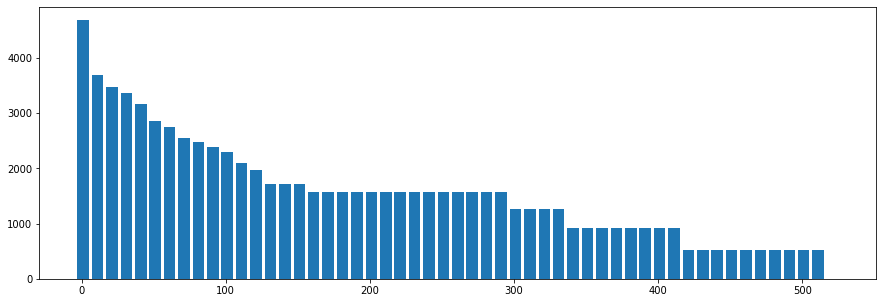

In [7]:
# Plot frequency of the data
counts = sorted([x for k,x in data_count], reverse=True)
x, y = [], []
for i in range(1, max(counts)+10, 10):
    x.append(i)
    y.append(sum(c for c in counts if i <= c))

print(f"Analyse on frequency:")
for freq in range(0,max(counts),50):
    print(f" - Sample frequency >= {freq:^3d} --> {round(100*sum(c for c in counts if freq <= c)/sum(counts)):3d}% of all samples ({len([c for c in counts if freq <= c])} samples in total)")

plt.figure(figsize=(15,5))
plt.bar(x, y, width=8)
plt.show()

## Model

Initialise the `EmbeddingModel`. This model consists of three main sub-models:
 - `encoder` to encode the raw sentences into machine-interpretable embeddings (multi-hot)
 - `embedder` to embed the multi-hot encoded vectors into dense embeddings
 - `clusterer` to cluster the dense embeddings and predict the best-suiting cluster

### Initialise

Initialise the model, by created each of its fundamental components. During this initialisation-step, you have the option to initialise the clusters yourselve (as done in this demo) or by answering a short survay of proposed clusters, done via CLI. The latter can be activated by setting `n_min_clusters` inside of `model.initialise_models` to a number larger than zero.

In [8]:
model = EmbeddingModel(
    name=name,
    path_model=Path.cwd() / f'demos/models/{name}',
    path_data=Path.cwd() / f'demos/data/{name}',
    clean_f=clean_f,
    vocab_size=200,
    model_layers=(50,50,),
    normalise=True,
    cluster_thr=.8,
)

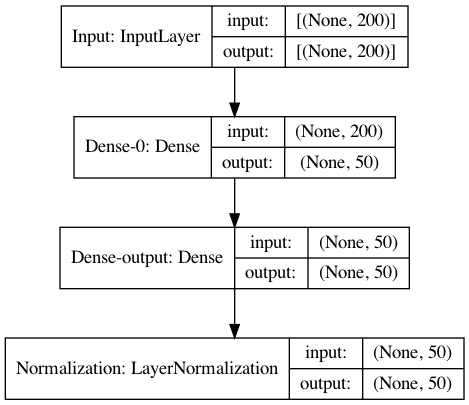

In [9]:
# Plot the model's architecture
tf.keras.utils.plot_model(
        model.embedder._model, Path.cwd() / f"demos/models/{name}/{model.embedder}.png",
        show_shapes=True,
)

In [10]:
# Create some initial clusters
model.initialise_models(
    data=data,
    reset_encoder=True,
    reset_embedder=True,
    reset_clusterer=True,
    n_min_clusters=0,
    show_overview=True,
)



Analysing encoder 'encoder-demo_default-bpe-200'

Analysing word 'ku leuven':
 --> Encoding: [38, 21]
 --> Word by word:
     - 38: ku
     - 21: leuven

Analysing word 'katholieke universiteit leuven':
 --> Encoding: [53, 29, 21]
 --> Word by word:
     - 53: katholieke
     - 29: universiteit
     - 21: leuven

Analysing word 'universiteit gent':
 --> Encoding: [29, 26]
 --> Word by word:
     - 29: universiteit
     - 26: gent

Analysing word 'hogeschool gent':
 --> Encoding: [32, 26]
 --> Word by word:
     - 32: hogeschool
     - 26: gent

Analysing word 'vrije universiteit brussel':
 --> Encoding: [102, 29, 57]
 --> Word by word:
     - 102: vrije
     - 29: universiteit
     - 57: brussel

Encoding the alphabet:
 - a = [36] = a
 - b = [42] = b
 - c = [64] = c
 - d = [177, 196] = d
 - e = [177, 176] = e
 - f = [174] = f
 - g = [12] = g
 - h = [78] = h
 - i = [141] = i
 - j = [177, 199] = j
 - k = [10] = k
 - l = [7] = l
 - m = [98] = m
 - n = [177, 178] = n
 - o = [81] = o
 - p

In [11]:
# Add training data manually
model.clusterer.add_clusters({
    'Catholic University of Leuven': ['kul', 'KU Leuven', 'katholieke universiteit leuven', 'Groep T', "Nayer Instituut", "universite de louvain"],
    'Free University of Brussels': ['VUB', 'Brussel Universiteit', 'vrije universiteit brussel'],
    'University of Ghent': ['Universiteit Gent', 'universite du gand', 'ugent'],
    'University of Hasselt': ['Hasselt Universiteit', 'uhasselt'],
    'University of Antwerp': ['UAntwerpen', 'universiteit antwerpen'],
    'Solvay Business School': ['Solvay', 'Vlerick Brussel'],
    'Vlerick Business School': ['Vlerick', 'Vlerick Leuven'],
    None: ['hogeschool gent','hogeschool antwerpen','bme gent', 'syntra hasselt', 'hogeschool', 'syntra', 'kaho leuven']
})
print(f"Only {round(100*len(model.clusterer.get_training_data())/len(data_unique), 2)}% of all (cleaned) data classified")

Only 4.82% of all (cleaned) data classified


In [12]:
# Add validation data manually
model.clusterer.add_validation({
    'Catholic University of Leuven': ['Louvain-la-Neuve', 'Groep T leuven', 'k u leuven'],
    'Free University of Brussels': ['vub Brussel', 'VU Brussel', 'brussel'],
    'University of Ghent': ['Université de Gand', 'rijksuniversiteit gent', 'ru gent'],
    'University of Hasselt': ['Hasselt', 'hasselt university', 'u hasselt'],
    'University of Antwerp': ['Universiteit van Antwerpen', 'u antwerpen', 'antwerpen'],
    'Solvay Business School': ['Solvay brussels school', 'solvay business school vub'],
    'Vlerick Business School': ['Vlerick business en management', 'vlerick leuven gent management school'],
    None: ['kaho sint lieven gent','hogent','karel de grote hogeschool katholieke hogeschool antwerpen','hogere zeevaartschool antwerpen','kaho gent']
})
print(f"{round(100*len(model.clusterer.get_validation_data())/len(data_unique), 2)}% of all (cleaned) data used for validation")

3.4% of all (cleaned) data used for validation


In [13]:
# Validate the non-trained model's performance
model.clusterer.set_centroids(
    embedding_f=model.embed,
)
_ = model.validate(
    print_result=True,
)


Validation result:
 - Global  Accuracy: 45.83% (11/24)
 - Accuracy cluster: 31.58% (6/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 25.0% (6/24)
 - Number of predicted None   : 75.0% (18/24)


## Training

Model-training is done on the labeled (supervised) data and tries to reshape the embedding-space in a meaningful way. This *reshaping* happens via a *push-pull technique*:
 - **push** This training step pushes away the samples that do not belong in the same cluster. Say for example you have the samples `KU Leuven` and `UGent`, these do not belong in the same cluster, and thus should have a low cosine-similarity.
 - **pull** This training step pulls all the samples that belong in the same cluster together. Say for example you have the samples `KU Leuven` and `KUL`, these two samples belong to the same cluster, and thus should be close to each other.
 
Every `iteration`, one push and one pull are performed (in that order). Every `epoch`, there is the option to check new samples for which the model is uncertain about. This enables you to only annotate the most relevant samples.

In [14]:
history = model.train(
    data=data_clean,
    epochs=1,
    iterations=32,
    batch_size=128,
    n_neg=16*128,
    n_pos=16*128,
    show_overview=True,
    debug=False,
)

Loss ???:   0%|          | 0/32 [00:00<?, ?it/s]

==> Running epoch 1 <==


Loss 0.03184: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]



Training-clustering overview:
 - Unclustered: 50.0% (362/724)
 - Largest cluster: 131
 - Average cluster: 45.25
 - Smallest cluster: 19

Validation result:
 - Global  Accuracy: 100.0% (24/24)
 - Accuracy cluster: 100.0% (19/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 79.17% (19/24)
 - Number of predicted None   : 20.83% (5/24)
INFO:tensorflow:Assets written to: /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/models/demo_default/embedder-demo_default-200-50-50-normalised/assets


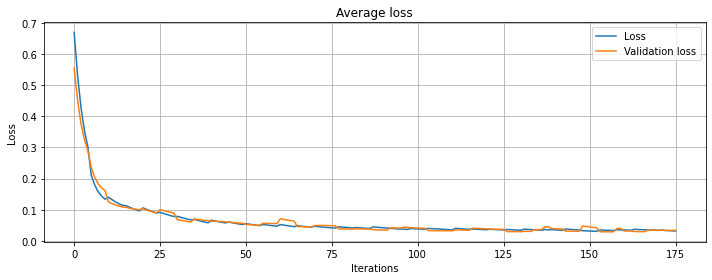

In [15]:
# Plot the loss-graphs
loss, val_loss = history['loss'], history['val_loss']
plt.figure(figsize=(10, 4))
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation loss')
plt.title("Average loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.tight_layout()
_ = plt.plot()

In [16]:
# Get overview of all validation predictions
val_result = model.validate(
    print_result=True,
)

print(f"\n\nClustering results:")
for a,b,c in val_result:
    print(f" - Clustering item '{a}'")
    print(f"   -->    Target-class: '{b}'")
    print(f"   --> Predicted-class: '{c}'")


Validation result:
 - Global  Accuracy: 100.0% (24/24)
 - Accuracy cluster: 100.0% (19/19)
 - Accuracy None   : 100.0% (5/5)
 - Number of predicted cluster: 79.17% (19/24)
 - Number of predicted None   : 20.83% (5/24)


Clustering results:
 - Clustering item 'hogent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'hogere zeevaartschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'kaho sint lieven gent'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'karel de grote hogeschool katholieke hogeschool antwerpen'
   -->    Target-class: 'None'
   --> Predicted-class: 'None'
 - Clustering item 'groep t leuven'
   -->    Target-class: 'Catholic University of Leuven'
   --> Predicted-class: 'Catholic University of Leuven'
 - Clustering item 'k u leuven'
   -->    Target-class: 'Catholic U

In [17]:
# Get closest cluster (together with cosine-similarity) for misclassified samples
misclassified = [a for a,b,c in val_result if b != c]
best_matches = model.get_cluster_prob(misclassified)

print(f"Closest cluster for misclassified samples:")
for item,(pred,certainty) in zip(misclassified, best_matches):
    print(f" - Clustering item '{item}'")
    print(f"   -->   Closest cluster: '{pred}'")
    print(f"   --> Cosine similarity: '{round(certainty,3):.3f}'")

Closest cluster for misclassified samples:


In [18]:
# Get ratio of data clustered
pred = model(data_unique)
pred_count = Counter(pred)
print(f"Prediction cluster-distribution:")
print(f" - Average of {round(100*len([p for p in pred if p])/len(pred), 2)}% clustered")
print(f" - Maximum cluster-size (not-None): {max(v for k,v in pred_count.items() if k)} samples")
print(f" - Average cluster-size (not-None): {round(sum(v for k,v in pred_count.items() if k)/(len(pred_count)-1))} samples")
print(f" - Minimum cluster-size (not-None): {min(v for k,v in pred_count.items() if k)} samples")
print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")

Prediction cluster-distribution:
 - Average of 49.15% clustered
 - Maximum cluster-size (not-None): 128 samples
 - Average cluster-size (not-None): 50 samples
 - Minimum cluster-size (not-None): 17 samples
 - Cluster by count:
   - None (359)
   - Catholic University of Leuven (128)
   - University of Antwerp (53)
   - Free University of Brussels (50)
   - University of Ghent (45)
   - University of Hasselt (34)
   - Solvay Business School (20)
   - Vlerick Business School (17)


In [19]:
# Get ratio of data clustered
pred = model(data)
pred_count = Counter(pred)
print(f"Prediction cluster-distribution, absolute figures:")
print(f" - Average of {round(100*len([p for p in pred if p])/len(pred), 2)}% clustered")
print(f" - Maximum cluster-size (not-None): {max(v for k,v in pred_count.items() if k)} samples")
print(f" - Average cluster-size (not-None): {round(sum(v for k,v in pred_count.items() if k)/(len(pred_count)-1))} samples")
print(f" - Minimum cluster-size (not-None): {min(v for k,v in pred_count.items() if k)} samples")
print(f" - Cluster by count:")
for k,v in sorted(pred_count.items(), key=lambda x: -x[1]):
    print(f"   - {k} ({v})")

Prediction cluster-distribution, absolute figures:
 - Average of 70.63% clustered
 - Maximum cluster-size (not-None): 1644 samples
 - Average cluster-size (not-None): 473 samples
 - Minimum cluster-size (not-None): 109 samples
 - Cluster by count:
   - Catholic University of Leuven (1644)
   - None (1377)
   - University of Ghent (627)
   - Free University of Brussels (372)
   - University of Antwerp (245)
   - Vlerick Business School (195)
   - University of Hasselt (120)
   - Solvay Business School (109)


## Visualise result

Visualise the embedding-space and (predicted) clusters using TensorBoard's Projector.

In [20]:
model.visualise_tensorboard(
    data=data_unique,
    path_projector=Path.cwd() / 'demos/projector',
    incl_none=False,
)

Run tensorboard in terminal:
tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_default

Or run tensorboard in notebook:
%load_ext tensorboard
%tensorboard --logdir /Users/rubenbroekx/Documents/Projects/SemiSupervisedClustering/demos/projector/demo_default


Another insightful visualisation is to show the softmax probabilities for each and every cluster. This can be done using the `seaborn` library.

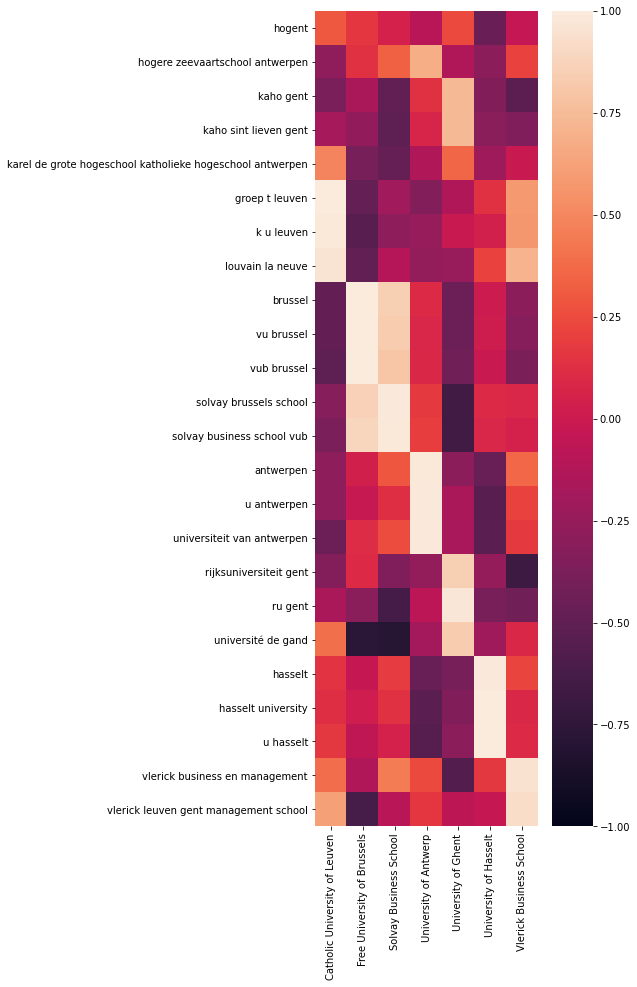

In [21]:
import seaborn as sns
validation_data = [k for k,_ in model.clusterer.get_validation_data()]
cluster_ids, probs = model.get_all_cluster_prob(validation_data)

plt.figure(figsize=(5,15))
sns.heatmap(probs, vmax=1, vmin=-1)
plt.xticks(ticks=[x+.5 for x in range(7)], labels=cluster_ids, rotation=90)
plt.yticks(ticks=[x+.5 for x in range(len(validation_data))], labels=validation_data, rotation=0)
_ = plt.show()

A last visualisation shows the similarities between the class centroids.

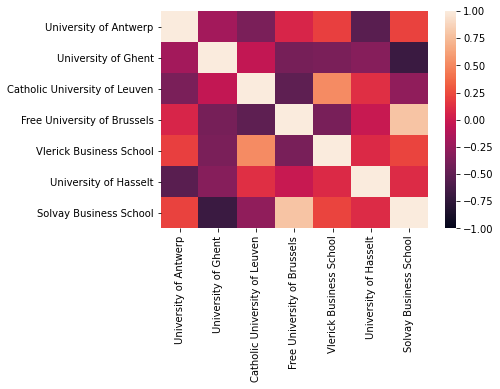

In [22]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Get current centroid-state
model.clusterer.set_centroids(embedding_f=model.embed)
centroids = model.clusterer.get_centroids()
labels, vectors = zip(*centroids.items())

# Calculate similarities and plot
sim = cosine_similarity(np.vstack(vectors))
sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmax=1, vmin=-1)
_ = plt.show()